# Notebook to analyse the GBT model predictions

## Imports

In [3]:
import pandas as pd
from pyspark import SparkConf
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql import functions as F
import matplotlib as mpl
from matplotlib import pyplot as plt

In [4]:
sty = "seaborn"
mpl.style.use(sty)

## create DataFrame from cleaned cluster trace Alibaba 2018

In [3]:
test_path = "../../out/model/eval/final/GBT5CV3parall_priorFeat_tune_maxDepth_Iter_Bins_03inst777SeedVal/part-00000-fcf17f91-2e4e-4fb3-830d-921eb502fd93-c000.csv.gz"
master = "local[2]"  # use 2 cores
app_name = "analyse prediction of Alibaba 2018 cluster trace"
config = SparkConf().setAll([
    ('spark.driver.memory', '3g')
])
spark_session = SparkSession.builder \
    .master(master) \
    .appName(app_name) \
    .config(conf=config) \
    .getOrCreate()

test = spark_session.read.csv(path=test_path, header=True, inferSchema=True)

22/03/05 21:46:48 WARN Utils: Your hostname, felix-Surface-Book resolves to a loopback address: 127.0.1.1; using 192.168.0.4 instead (on interface wlp3s0)
22/03/05 21:46:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/03/05 21:46:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
model_name = "GBT5CV3parall_priorFeat_tune_maxDepth_Iter_Bins_03inst777Seed"
# model_name = "GBTNested5CV3parall_priorFeat_tune_maxDepth_Iter_03inst"  # for 20 iterations

## Simple analysis

In [5]:
# GBTCVvalidation_006 204092
# GBTCVvalidation_0015 166009
# GBTCVLocalValidation 1246728
# GBTCVVal_03PERC_0015FRAC_066_033SPLIT_36SEED 422746
# gbtcv_priorfeatures_03inst_0802splitvalidation 149366
# GBTNested5CV3parall_priorFeat_tune_maxDepth_Iter_03instVal 279576
# GBT5CV3parall_priorFeat_tune_maxDepth_Iter_Bins_03inst777Seed 280125
test.count()

280125

In [6]:
test.dtypes

[('task_name', 'string'),
 ('job_name', 'string'),
 ('task_id_num', 'int'),
 ('instance_num', 'int'),
 ('task_type', 'int'),
 ('status', 'string'),
 ('start_time', 'int'),
 ('end_time', 'int'),
 ('plan_cpu', 'double'),
 ('plan_mem', 'double'),
 ('map_reduce', 'string'),
 ('earliest', 'int'),
 ('sched_intv', 'int'),
 ('job_exec', 'int'),
 ('logical_job_name', 'string'),
 ('latest', 'int'),
 ('task_duration', 'int'),
 ('tts_task', 'int'),
 ('mtts_task', 'double'),
 ('ttf_task', 'int'),
 ('ttr_task', 'int'),
 ('reduce_checkpoint', 'int'),
 ('second_quant_checkpoint', 'int'),
 ('third_quant_checkpoint', 'int'),
 ('instance_name', 'string'),
 ('instance_task_type', 'int'),
 ('instance_status', 'string'),
 ('instance_start_time', 'int'),
 ('instance_end_time', 'int'),
 ('machine_id', 'string'),
 ('seq_no', 'int'),
 ('total_seq_no', 'int'),
 ('cpu_avg', 'double'),
 ('cpu_max', 'double'),
 ('mem_avg', 'double'),
 ('mem_max', 'double'),
 ('labels', 'int'),
 ('instance_num_imp', 'int'),
 ('task_

In [7]:
# GBTCVVal_03PERC_0015FRAC_066_033SPLIT_36SEED 42
# GBTNested5CV3parall_priorFeat_tune_maxDepth_Iter_03instVal 49
len(test.dtypes)

49

In [8]:
num_cols = [x[0] for x in test.dtypes if x[1] == 'int' or x[1] == 'double']
num_cols

['task_id_num',
 'instance_num',
 'task_type',
 'start_time',
 'end_time',
 'plan_cpu',
 'plan_mem',
 'earliest',
 'sched_intv',
 'job_exec',
 'latest',
 'task_duration',
 'tts_task',
 'mtts_task',
 'ttf_task',
 'ttr_task',
 'reduce_checkpoint',
 'second_quant_checkpoint',
 'third_quant_checkpoint',
 'instance_task_type',
 'instance_start_time',
 'instance_end_time',
 'seq_no',
 'total_seq_no',
 'cpu_avg',
 'cpu_max',
 'mem_avg',
 'mem_max',
 'labels',
 'instance_num_imp',
 'task_type_imp',
 'plan_mem_imp',
 'seq_no_imp',
 'sched_intv_imp',
 'job_exec_imp',
 'prediction',
 'plan_cpu_imp_scaled',
 'proba0',
 'rawPred0',
 'proba1',
 'rawPred1']

In [9]:
# GBTCVVal_03PERC_0015FRAC_066_033SPLIT_36SEED 34
len(num_cols)

41

## Map and Reduce Distribution

In [10]:
test.groupby("map_reduce").count().show()

+----------+------+
|map_reduce| count|
+----------+------+
|         m|245882|
|         r| 34243|
+----------+------+



In [11]:
mr_ratio = 245179 / 34382
mr_ratio
# usually around 10%

7.131027863416904

## Labels distribution

In [12]:
test.groupby("labels").count().show()
# usually 50/50

+------+------+
|labels| count|
+------+------+
|     1|151210|
|     0|128915|
+------+------+



## Analyse prediction results

In [13]:
test.select("prediction").distinct().show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+



In [14]:
test.groupBy("prediction").count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|156222|
|       1.0|123903|
+----------+------+



In [15]:
test.groupBy("prediction", "labels").count().show()

+----------+------+------+
|prediction|labels| count|
+----------+------+------+
|       1.0|     0|  5087|
|       0.0|     0|123828|
|       0.0|     1| 32394|
|       1.0|     1|118816|
+----------+------+------+



## Classification results

### Model (selection) inspection
- results across folds
https://stackoverflow.com/questions/51230726/extract-results-from-crossvalidator-with-paramgrid-in-pyspark

In [16]:
from pyspark.ml.tuning import CrossValidatorModel
model_select_name = "GBT5CV3parall_priorFeat_tune_maxDepth_Iter_Bins_03inst777Seed_select"
model_select_path = f"../../out/model/dump/final/{model_select_name}"
cv_select_model = CrossValidatorModel.load(model_select_path)

In [17]:
model_select_params = params = [{p.name: v for p, v in m.items()} for m in cv_select_model.getEstimatorParamMaps()]
model_select_params

[{'maxBins': 32, 'maxDepth': 2, 'maxIter': 2},
 {'maxBins': 2200, 'maxDepth': 2, 'maxIter': 2},
 {'maxBins': 32, 'maxDepth': 5, 'maxIter': 2},
 {'maxBins': 2200, 'maxDepth': 5, 'maxIter': 2},
 {'maxBins': 32, 'maxDepth': 2, 'maxIter': 5},
 {'maxBins': 2200, 'maxDepth': 2, 'maxIter': 5},
 {'maxBins': 32, 'maxDepth': 5, 'maxIter': 5},
 {'maxBins': 2200, 'maxDepth': 5, 'maxIter': 5}]

In [18]:
model_select_metrics = cv_select_model.avgMetrics
model_select_metrics

[0.8224807349368444,
 0.823509613701481,
 0.9165091102449674,
 0.9192554928537607,
 0.8503284862858239,
 0.8442333801071091,
 0.93992680568921,
 0.9418317416814705]

In [19]:
import pandas as pd
assert len(model_select_params) == len(model_select_metrics)
assert type(model_select_params) == type(model_select_metrics)
params_metrics_df = pd.DataFrame.from_dict([{cv_select_model.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(model_select_params, model_select_metrics)
])
params_metrics_df = params_metrics_df.sort_values(by="areaUnderROC", ascending=False)
params_metrics_df

,areaUnderROC,maxBins,maxDepth,maxIter
7,0.941832,2200,5,5
6,0.939927,32,5,5
3,0.919255,2200,5,2
2,0.916509,32,5,2
4,0.850328,32,2,5
5,0.844233,2200,2,5
1,0.823510,2200,2,2
0,0.822481,32,2,2


In [20]:
param_metrics_latex = params_metrics_df.to_latex()
# we need print for line breaks etc
print(param_metrics_latex)

\begin{tabular}{lrrrr}
\toprule
{} &  areaUnderROC &  maxBins &  maxDepth &  maxIter \\
\midrule
7 &      0.941832 &     2200 &         5 &        5 \\
6 &      0.939927 &       32 &         5 &        5 \\
3 &      0.919255 &     2200 &         5 &        2 \\
2 &      0.916509 &       32 &         5 &        2 \\
4 &      0.850328 &       32 &         2 &        5 \\
5 &      0.844233 &     2200 &         2 &        5 \\
1 &      0.823510 &     2200 &         2 &        2 \\
0 &      0.822481 &       32 &         2 &        2 \\
\bottomrule
\end{tabular}



### Model (training) inspection

In [7]:
from pyspark.ml.tuning import CrossValidatorModel

model_path = f"../../out/model/dump/final/{model_name}"
# load CV model and get the pipeline
cv_model = CrossValidatorModel.load(model_path)
# cv parameters
num_folds = cv_model.getNumFolds()
pipeline_model = cv_model.bestModel
gbt_model = pipeline_model.stages[-1]
# set parameters
max_bins = gbt_model.getMaxBins()
min_inst_node = gbt_model.getMinInstancesPerNode()
# tuned parameters
max_depth = gbt_model.getMaxDepth()
max_iter = gbt_model.getMaxIter()
# model parameters
loss_type = gbt_model.getLossType()
# result parameters
num_trees = gbt_model.getNumTrees
total_num_nodes = gbt_model.totalNumNodes
# spark parameters
check_intv = gbt_model.getCheckpointInterval()

In [8]:
print(f"""
set parameters: \n
max_bins: {max_bins} \n
min_inst_node: {min_inst_node} \n
cv parameters: \n
num_folds: {num_folds} \n
tuned parameters: \n
max_depth: {max_depth} \n
max_iter: {max_iter} \n
model parameters: \n
loss_type: {loss_type} \n
result parameters: \n
num_trees: {num_trees} \n
total_num_nodes: {total_num_nodes} \n
check_intv: {check_intv}
""")


set parameters: 

max_bins: 50 

min_inst_node: 400 

cv parameters: 

num_folds: 5 

tuned parameters: 

max_depth: 5 

max_iter: 20 

model parameters: 

loss_type: logistic 

result parameters: 

num_trees: 20 

total_num_nodes: 978 

check_intv: 5



### Tree weights

In [23]:
import pandas as pd
trees = gbt_model.trees
weights = gbt_model.treeWeights
trees_weights = zip(trees, weights)
list(trees_weights)


[(DecisionTreeRegressionModel: uid=dtr_0c7bd8cd19e3, depth=5, numNodes=59, numFeatures=2175,
  1.0),
 (DecisionTreeRegressionModel: uid=dtr_5b4c7cbd3fa4, depth=5, numNodes=63, numFeatures=2175,
  0.1),
 (DecisionTreeRegressionModel: uid=dtr_373b47c55965, depth=5, numNodes=63, numFeatures=2175,
  0.1),
 (DecisionTreeRegressionModel: uid=dtr_3e75c64b6f49, depth=5, numNodes=63, numFeatures=2175,
  0.1),
 (DecisionTreeRegressionModel: uid=dtr_3e8b9bef0191, depth=5, numNodes=61, numFeatures=2175,
  0.1)]

In [24]:
data = [{"uid": tree.uid, "weight": weight, "numNodes": tree.numNodes, "depth": tree.depth, "numFeatures": tree.numFeatures} for tree, weight in zip(trees, weights)]
trees_weights_df = pd.DataFrame.from_dict(data)
trees_weights_df.set_index(keys="uid", drop=True, inplace=True)
#trees_weights_df = trees_weights_df.sort_values(by="weight", ascending=False)
print(trees_weights_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  weight &  numNodes &  depth &  numFeatures \\
uid              &         &           &        &              \\
\midrule
dtr\_0c7bd8cd19e3 &     1.0 &        59 &      5 &         2175 \\
dtr\_5b4c7cbd3fa4 &     0.1 &        63 &      5 &         2175 \\
dtr\_373b47c55965 &     0.1 &        63 &      5 &         2175 \\
dtr\_3e75c64b6f49 &     0.1 &        63 &      5 &         2175 \\
dtr\_3e8b9bef0191 &     0.1 &        61 &      5 &         2175 \\
\bottomrule
\end{tabular}



## Evaluate gradient boosting iterations

### read the data and reproduce the datasets

In [5]:
# read dataset
data_name = "batch_jobs_clean_03inst_1task_00015S_1F"
data_path = f"../../out/clean/{data_name}/*.csv.gz"
data = spark_session.read.csv(data_path, header=True, inferSchema=True)
# reproduce training set
seed = 61
fractions = {0: 0.50, 1: 0.50}
training = data.sampleBy(col="labels", fractions=fractions, seed=seed)
# stratified (50/25/25) split to have 50% of the data for training, 25 for validation (hyper
rest = data.subtract(training)
fractions = {0: 0.25, 1: 0.25}
validation = rest.sampleBy(col = "labels", fractions = fractions, seed = seed)
test_raw = rest.subtract(validation)

In [15]:
figsize = (8,6)
train_transf = pipeline_model.transform(training)
gradient_boosting_eval = gbt_model.evaluateEachIteration(dataset=train_transf)
gradient_boosting_eval_df = pd.DataFrame(gradient_boosting_eval)

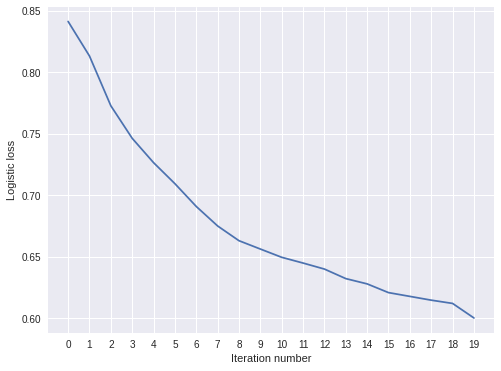

In [16]:
# GBTNested5CV3parall_priorFeat_tune_maxDepth_Iter_03inst for 20 iterations
fig = plt.figure(figsize=figsize)
iters = range(0,(max_iter))
plt.plot(gradient_boosting_eval_df)
plt.xticks(ticks=iters, labels=iters)
#plt.title("Logistic Loss for each iteration of gradient boosting")
plt.xlabel("Iteration number")
plt.ylabel("Logistic loss")
plt.savefig(f"../../out/analysis/model/log_loss_per_iter_{model_name}.pdf", format="pdf")
plt.show()

### Classification report

In [28]:
from sklearn.metrics import classification_report
import pandas as pd

y_true = test.select("labels").toPandas()
y_pred = test.select("prediction").toPandas()
target_names = ['success', 'failed']
# "support means" number of rows per class
report = classification_report(
    y_true,
    y_pred,
    target_names=target_names,
    output_dict=True
)
# get a sub set of the keys to remove unwanted metrics
per_class = dict((k,report[k]) for k in report.keys() if k in target_names)
# we cant use accuracy for imbalanced classes
per_class = pd.DataFrame.from_dict(per_class).round(decimals=4)
per_class

,success,failed
precision,0.7926,0.9589
recall,0.9605,0.7858
f1-score,0.8686,0.8638
support,128915.0000,151210.0000


In [29]:
latex = per_class.to_latex()
# put this inside \begin{table}...
print(latex)

\begin{tabular}{lrr}
\toprule
{} &      success &       failed \\
\midrule
precision &       0.7926 &       0.9589 \\
recall    &       0.9605 &       0.7858 \\
f1-score  &       0.8686 &       0.8638 \\
support   &  128915.0000 &  151210.0000 \\
\bottomrule
\end{tabular}



## confusion matrix
- normalized (values between 0-1)

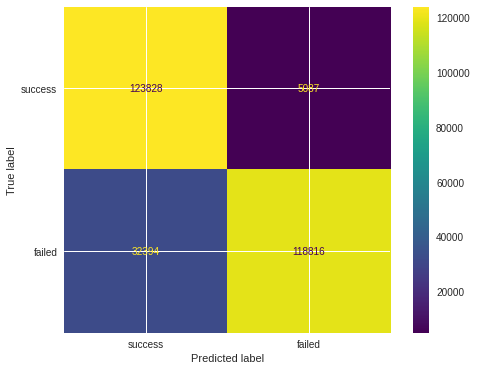

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred, labels=[0,1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names
                              )
disp.plot()
#("GBT model confusion matrix")
# in jupyter the size doesnt change but in the saved figure
disp.figure_.set_figwidth(8)
disp.figure_.set_figheight(6)
disp.figure_.savefig(f"../../out/analysis/model/absConfMatr_{model_name}.pdf", format="pdf")
plt.show()

In [31]:
import matplotlib.pyplot as plt

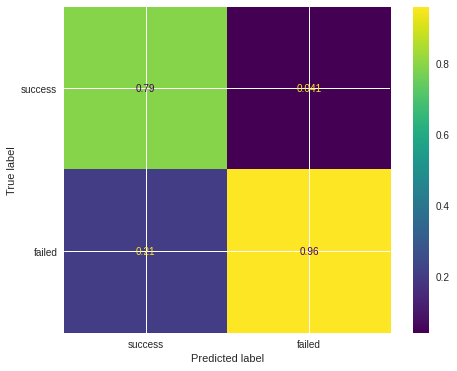

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred, labels=[0,1], normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names
                              )
disp.plot()
#plt.title("GBT model normalized confusion matrix")
# in jupyter the size doesnt change but in the saved figure
disp.figure_.set_figwidth(8)
disp.figure_.set_figheight(6)
disp.figure_.savefig(f"../../out/analysis/model/normConfMatr_{model_name}.pdf", format="pdf")
plt.show()

### PR curve
- Precision recall curves

### ROC curve
- and "area under curve" metric

In [33]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
fpr, tpr, thresholds, roc_auc

(array([0.        , 0.03946011, 1.        ]),
 array([0.        , 0.78576814, 1.        ]),
 array([2., 1., 0.]),
 0.8731540138267901)

In [1]:
# to prevent recomp

fpr, tpr, thresholds, roc_auc = [0.0, 0.03946011, 1.0], [0.        , 0.78576814, 1.       ], [2, 1, 0], 0.8731540138267901

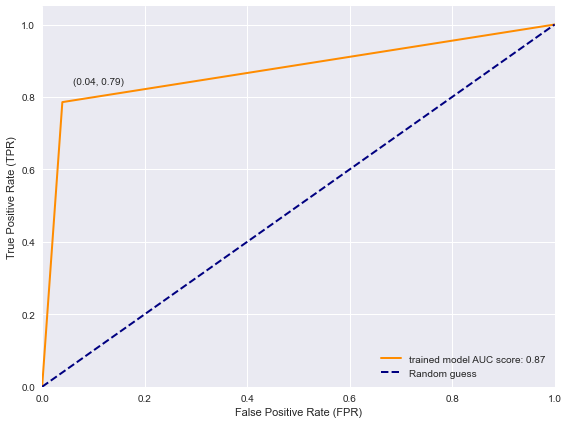

In [8]:
plt.figure(figsize=(8,6))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="trained model AUC score: %0.2f" % roc_auc,
)
plt.rcParams["figure.autolayout"] = True
# the diagonal line
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# the ROC point from the confusion matrix
#plt.plot(fpr, tpr,"ro")
# show point coordinates
for i, j in zip(fpr, tpr):
        if i and j not in [0.00, 1.0]:
            plt.text(i+0.02, j+0.05, '({0:.2f}, {1:.2f})'.format(i, j))
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
#plt.title("Receiver operating characteristic (ROC) curve")
plt.legend(loc="lower right")
# plt.figure(figsize=(8,6))
plt.savefig(f"../../out/analysis/model/rocCurve_{model_name}.pdf", format="pdf")
plt.show()

<Figure size 576x432 with 0 Axes>

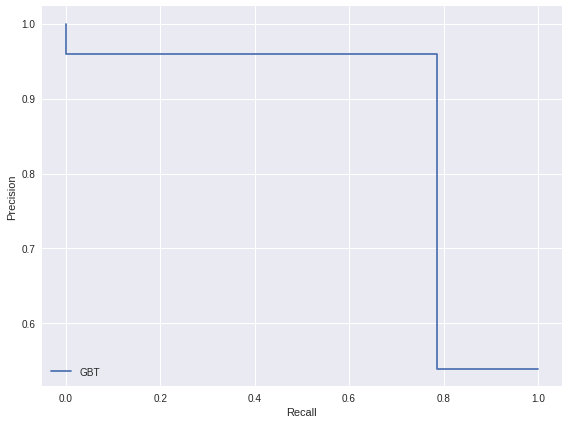

In [35]:
from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)

precision, recall, _ = precision_recall_curve(y_true, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name="GBT")
plt.figure(figsize=(8,6))
disp.plot()
#plt.title("Precision-Recall (PR) curve")
disp.figure_.set_figwidth(8)
disp.figure_.set_figheight(6)
disp.figure_.savefig(f"../../out/analysis/model/prCurve_{model_name}.pdf", format="pdf")
plt.show()

## Analysis of checkpoints per job of a logical job

In [36]:
test.select("start_time", "end_time", "logical_job_name", "job_name", "task_id_num", "task_name", "instance_name", "instance_num", "job_exec", "labels", "prediction").show(5, False)

+----------+--------+----------------+---------+-----------+---------+-------------+------------+--------+------+----------+
|start_time|end_time|logical_job_name|job_name |task_id_num|task_name|instance_name|instance_num|job_exec|labels|prediction|
+----------+--------+----------------+---------+-----------+---------+-------------+------------+--------+------+----------+
|320685    |321174  |L_j_2333041     |j_655136 |11         |M11      |ins_79882461 |3484        |15844   |0     |0.0       |
|316726    |316757  |L_j_593524      |j_2241669|2          |M2       |ins_10816351 |19785       |122410  |0     |0.0       |
|338377    |338392  |L_j_2678067     |j_4076536|3          |M3_2     |ins_19675257 |53667       |54101   |1     |1.0       |
|583659    |583669  |L_j_1481870     |j_481775 |5          |M5       |ins_893023079|6204        |131027  |1     |0.0       |
|663230    |663462  |L_j_4119889     |j_3719190|5          |M5_4     |ins_541043358|6667        |32770   |1     |0.0       |


In [37]:
# this ljn has a lot of checkpoints
arbitrary_ljn ="L_j_3478541"
ljn_jobs = test.filter(
    (F.col("logical_job_name")==arbitrary_ljn)
)
ljn_jobs = ljn_jobs.withColumn("task_labels",
                               F.when(F.lower(F.col("status"))=="failed", 1).otherwise(0)
                               )

In [38]:
ljn_jobs.count()

37111

In [39]:
ljn_jobs.select("job_name").distinct().count()

10608

In [40]:
ljn_pdf = ljn_jobs.groupBy("job_name", "end_time", "instance_num").agg(
    F.sum("task_labels").alias("task_failures"),
    F.sum("labels").alias("inst_failures"),
    F.sum(F.col("prediction")).alias("inst_failures_predictions")
).sort(F.col("end_time"), ascending=False).toPandas()

In [41]:
ljn_pdf

,job_name,end_time,instance_num,task_failures,inst_failures,inst_failures_predictions
0,j_1399367,693344,2397,0,0,0.0
1,j_3507160,691184,532,0,0,0.0
2,j_1231657,690969,4444,0,0,0.0
3,j_1622822,690911,1936,0,0,0.0
4,j_2099208,690789,4764,0,0,0.0
...,...,...,...,...,...,...
10603,j_204597,0,54,0,3,0.0
10604,j_1618497,0,10836,0,710,0.0
10605,j_4051376,0,10836,0,73,0.0
10606,j_2902016,0,19402,0,0,0.0


Text(0, 0.5, 'No. Failures')

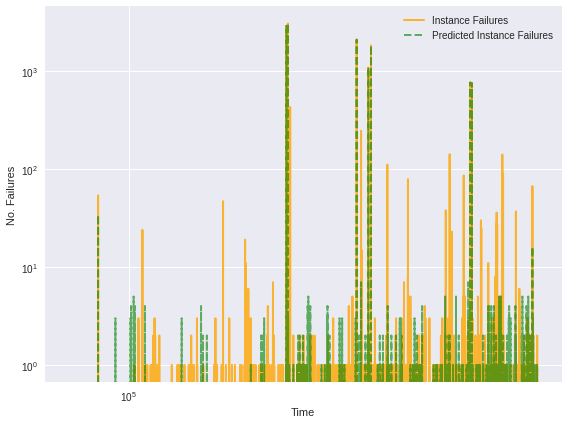

In [42]:
# Creating figure and axis objects using subplots()
fig, ax = plt.subplots(figsize=[8, 6])
plt.plot(
    ljn_pdf['end_time'],
    ljn_pdf['inst_failures'],
    label="Instance Failures",
    color="orange",
    alpha=0.8,
    lw=2
)

plt.plot(
    ljn_pdf['end_time'],
    ljn_pdf['inst_failures_predictions'],
    label="Predicted Instance Failures",
    color="green",
    linestyle="dashed",
    alpha=0.6,
    lw=2
)
ax.set_xscale('log')
ax.set_yscale('log')
"""
plt.plot(ljn_pdf['end_time'],
         ljn_pdf['task_failures'],
         label="Task Failures",
         alpha=0.6
         )
"""
plt.legend()

ax.set_xlabel('Time')
ax.set_ylabel('No. Failures')

In [43]:
ljn_jobs.groupBy("logical_job_name", "job_name", "instance_num", "job_exec").agg(
    F.sum("prediction").alias("check_count"),
    F.sum("labels").alias("fail_count")).sort(F.col("check_count"), ascending=False).show()

+----------------+---------+------------+--------+-----------+----------+
|logical_job_name| job_name|instance_num|job_exec|check_count|fail_count|
+----------------+---------+------------+--------+-----------+----------+
|     L_j_3478541|j_1157307|        9999|  119574|     3077.0|      3076|
|     L_j_3478541| j_772351|        9999|  118210|     2920.0|      2919|
|     L_j_3478541|j_3243463|       16896|  196985|     2105.0|      2105|
|     L_j_3478541|j_3754361|        6476|  215958|     1838.0|      1838|
|     L_j_3478541|j_1947252|        3447|  212242|     1091.0|      1091|
|     L_j_3478541|j_2109726|        3333|  388437|      770.0|       769|
|     L_j_3478541|j_4069746|        3333|  391957|      758.0|       758|
|     L_j_3478541|j_2691344|        3333|  392412|      758.0|       757|
|     L_j_3478541|j_3175082|        3447|  213348|      251.0|       250|
|     L_j_3478541|j_2424359|         302|     338|       34.0|        54|
|     L_j_3478541|j_1450697|         5